In [ ]:
# default_exp pipeline

# Module pipeline

> Here we have the Nodes wrapping around our core functions, which can be added to a Nipype workflow to process your input images. These definitions here are our custom functions and Nipype Nodes knotted together, which creates a working pipeline.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
%%capture
#export
import os, sys
from shutil import which
from pathlib import Path

import pipetography.core as ppt

from nipype import IdentityInterface, Function
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline import Node, MapNode, Workflow
from nipype.interfaces.freesurfer.preprocess import ReconAll
from nipype.interfaces.mrtrix3.utils import BrainMask, TensorMetrics, DWIExtract, MRMath
from nipype.interfaces.mrtrix3.preprocess import MRDeGibbs, DWIBiasCorrect
from nipype.interfaces.mrtrix3.reconst import FitTensor
from nipype.interfaces import ants
from nipype.interfaces import fsl

#### A `pipeline` class that puts everything together.

In [ ]:
# export
class pipeline:
    """
    A class containing functionalities and inputs to the image processing pipeline.
    For step-by-step preprocessing example instead of a connected pipeline, see `core` page.
    
    This pipeline makes the following assumptions:
        - Data input is in valid BIDS format
        - Align all anat and dwi images to MNI space via ACPC HCP procedure
    
    Input: 
        BIDS_dir (str): Valid BIDS directory with DWI modality
        RPE_design (str): Reverse phase encoding design for DWI
        Regrid (Bool): [False] Whether to resample DWI to a template image's voxel grid
        mrtrix_nthreads (Int): [0] Number of paralel threads to perform mrtrix tasks, default to 0, which disables multi-threading
    Attributes:
        data_dir (str): input BIDS data directory
        sub_list (List): List of subject IDs read from the BIDS directory
        layout (PyBIDS Layout): PyBIDS Layout for querying
        bfiles_fsl (tuple)
    """

    def __init__(self, BIDS_dir="data", RPE_design="-rpe_none", Regrid=False, mrtrix_nthreads=0):
        # Nodes are initialized with the bare minimum of inputs or default parameters
        # Remaining inputs are either connected in the Nipype workflow or are user inputs
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
        # Input variables to pipeline
        self.bids_dir = BIDS_dir
        self.RPE_design = RPE_design
        self.Regrid = Regrid
        self.mrtrix_nthreads = mrtrix_nthreads
        
        # Create derivatives folder if it doesn't exist:
        if not os.path.exists(os.path.join(BIDS_dir, '..', 'derivatives')):
            print('No derivatives folder, creating it at {}'.format(
                os.path.join(Path(BIDS_dir).parent, 'derivatives'))
                 )
            os.makedirs(os.path.join(Path(BIDS_dir).parent, 'derivatives'))
        elif os.path.exists(os.path.join(Path(BIDS_dir).parent, 'derivatives')):
            print('derivatives folder found at {}'.format(os.path.join(Path(BIDS_dir).parent, 'derivatives')))
        
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
        # Generate BIDS Layout, and create subject ID list:
        self.sub_list, self.layout = ppt.get_subs(self.bids_dir)
        
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
        # Create BIDS data input node:
        self.subject_source = Node(IdentityInterface(fields=["subject_id"]), name="sub_source")
        # This node will create iterables from the subject ID list:
        self.subject_source.iterables = [("subject_id", self.sub_list)]
        # string templates for images:
        self.anat_file = os.path.join(
            'sub-{subject_id}', 'ses-*', 'anat', 'sub-{subject_id}_ses-*_T1w.nii.gz'
        )
        self.dwi_file = os.path.join(
            "sub-{subject_id}", "ses-*", "dwi", "sub-{subject_id}_ses-*_dwi.nii.gz",
        )
        self.b_files = os.path.join(
            "sub-{subject_id}", "ses-*", "dwi", "sub-{subject_id}_ses-*_dwi.bv*"
        )
        self.sub_template = {"anat": self.anat_file, "dwi": self.dwi_file, "b_files": self.b_files}        
       
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
        # node for selecting images and bfiles
        self.select_files = Node(
            SelectFiles(self.sub_template, base_directory=self.bids_dir), name="select_files",
        )
        self.sub_grad_files = MapNode(
            Function(input_names=["sub_dwi"], output_names=["fslgrad"], function=ppt.get_sub_gradfiles),
            name = 'sub_grad_files',
            iterfield = "sub_dwi"
        )
        self.bfiles_input = Node(
            Function(
                input_names=["in_List"], output_names=["out_path"], function=ppt.get_bfiles_tuple,
            ),
            name="select_bfiles",
        )
        
        self.get_fs_id = MapNode(
            Function(input_names = ["anat_files"], output_names = ["fs_id_list"],
                     function = ppt.anat2id),
            name = 'freesurfer_sub_id', iterfield = "anat_files"
        )
        
        # node for gettinng meta data with BIDS Layout:
        self.get_metadata = MapNode(
            Function(input_names = ["path", "bids_dir"], output_names = ["ReadoutTime","PE_DIR"],
                     function = ppt.BIDS_metadata), name = 'get_metadata', iterfield="path")
        
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
        # ACPC HCP MNI152 alignment nodes:
        # first define template location in FSL:
        self.MNI_template = os.path.expandvars('$FSLDIR/data/standard/MNI152_T1_1mm.nii.gz')
        print('ACPC Alignment will use FSL MNI 1mm template')
        # The following nodes creates transformation matrices and applys them to align our T1 image
        self.reduceFOV = MapNode(fsl.utils.RobustFOV(), name="reduce_FOV", iterfield="in_file")
        self.xfminverse = MapNode(fsl.utils.ConvertXFM(), name="transform_inverse", iterfield="in_file")
        self.flirt = MapNode(fsl.preprocess.FLIRT(), name="FLIRT", iterfield="in_file")
        self.concatxfm = MapNode(fsl.utils.ConvertXFM(), name="concat_transform", iterfield=["in_file", "in_file2"])
        self.alignxfm = MapNode(ppt.fslaff2rigid(), name='aff2rigid', iterfield="in_file")
        self.ACPC_warp = MapNode(fsl.preprocess.ApplyWarp(), name='apply_warp', iterfield=["in_file", "premat"])
        
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
        # FreeSurfer recon-all mainly for WM segmentation
        # we are greedy so we just let it segment and produce everything
        self.reconall = MapNode(ReconAll(), name='FSrecon', iterfield=["T1_files","subject_id"])
        
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
        # Preparation nodes (mask, check gradient, convert):
        # first convert our input nifti to mrtrix3 format
        self.mrconvert = MapNode(ppt.Convert(), name='mrtrix_image', iterfield=["in_file", "grad_fsl"])
        # create raw DWI brain mask
        self.createMask = MapNode(BrainMask(), name='raw_dwi2mask', iterfield='in_file')
        # check for gradients and create a new image with correct gradients
        self.GradCheck = MapNode(ppt.GradCheck(), name='dwigradcheck', iterfield=['in_file','mask_file'])
        self.NewGradMR = MapNode(ppt.Convert(), name='mrconvert', iterfield = ["in_file", 'grad_file'])
        
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
        # Preprocessing nodes:
        # First MPPCA denoise with dwidenoise
        self.denoise = MapNode(ppt.dwidenoise(), name="denoise", iterfield="in_file")
        # Gibb's ringing artifact removal:
        self.degibbs = MapNode(MRDeGibbs(), name="ringing_removal", iterfield="in_file")
        # DWI Distortion correction with mrtrix3's dwifslpreproc:
        self.fslpreproc = MapNode(ppt.dwipreproc(), name = "dwifslpreproc", iterfield=["in_file", "grad_file", "RO_time", "pe_dir"])
        # Bias field correction using ANTS:
        self.biascorrect = MapNode(ppt.BiasCorrect(), name = 'dwibiascorret', iterfield=["in_file", "grad_file"])
        # Rician background noise removal requires multiple nodes:
        # create new gradient file because we have changed the data extensively now:
        self.grad_info = MapNode(ppt.MRInfo(), name = 'NewGradient', iterfield = ["in_file", "grad_file"])
        # get background low noise map:
        self.low_noise_map = MapNode(ppt.CheckNIZ(), name = 'LowNoiseMap', iterfield=["isfinite", "cond_if"])
        # Compute Rician noise:
        self.rician_noise = MapNode(ppt.RicianNoise(), name = 'RicianNoise', iterfield = ["in_file","lownoisemap"])
        self.check_rician = MapNode(ppt.CheckNIZ(), name = 'NoiseComparison', iterfield = ["isfinite", "cond_if"])
        self.convert_rician = MapNode(ppt.Convert(), name = "ConvnertRician", iterfield = ["in_file", "grad_file"])
        # DWI image intensity normalization:
        # first create a DWI brain mask:
        self.dwi_mask = MapNode(BrainMask(), name='dwi2mask', iterfield='in_file')
        # create a FA WM mask:
        self.fit_tensor = MapNode(FitTensor(), name='dwi2tensor', iterfield=['in_file', 'in_mask'])
        self.tensor_FA = MapNode(TensorMetrics(), name='tensor2metrics', iterfield='in_file')
        self.wm_mask = MapNode(ppt.MRThreshold(), name = 'mrthreshold', iterfield='in_file')
        # finally intensity normalization:
        self.norm_intensity = MapNode(ppt.DWINormalize(), name='dwinormalise', iterfield=['in_file','mask_file'])
        
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
        # Create new B0 and DWI brain masks with updated images to prep for re-alignement to MNI space
        self.sub_b0extract = MapNode(DWIExtract(),  name='sub_b0extract', iterfield='in_file')
        self.sub_b0mean = MapNode(MRMath(), name='sub_mrmath_mean', iterfield='in_file')
        self.sub_b0mask = MapNode(BrainMask(), name='sub_dwi2mask', iterfield='in_file')
        # convert from mif to nift
        self.sub_convert_dwi = MapNode(ppt.Convert(), name="sub_dwi2nii", iterfield="in_file")
        self.sub_convert_mask = MapNode(ppt.Convert(), name="sub_mask2nii", iterfield="in_file")
        # apply mask to B0 volume:
        self.sub_apply_mask = MapNode(fsl.ApplyMask(), name='sub_ApplyMask', iterfield=["in_file", "mask_file"])
        
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
        # Align DWI to ANAT w/ ACPC HCP MNI152 space
        # first extract the brain:
        self.t1_bet = MapNode(fsl.preprocess.BET(), name='fsl_bet', iterfield="in_file")
        # align DWI to ANAT... get transformation matrix first
        self.epi_reg = MapNode(fsl.epi.EpiReg(), name='fsl_epireg', iterfield=['epi','t1_head', 't1_brain'])
        # convert transformation matrix to mrtrix format
        self.acpc_xfm = MapNode(ppt.TransConvert(), name='transformconvert', iterfield=["flirt_xfm","flirt_in","flirt_ref"])
        # apply the transformation:
        self.apply_xfm = MapNode(ppt.MRTransform(), name='mrtransform', iterfield=["in_file", "linear_xfm"])
        
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
        # if regrid = True, do regridding, if False, we skip these nodes in workflow:
        # this is mainly done to isotropically upsample your DWI data
        # Partial upsampling is not supported and not recommended
        self.regrid = MapNode(ppt.MRRegrid(), name='mrgrid', iterfield='in_file')
        
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
        # Recreate final DWI/Reference images and their corresponding gradient/info files:
        self.mni_b0extract = MapNode(DWIExtract(), name='mni_b0extract', iterfield='in_file')
        self.mni_b0mean = MapNode(MRMath(), name='mni_mrmath_mean', iterfield='in_file')
        self.mni_b0mask = MapNode(BrainMask(), name='mni_dwi2mask', iterfield='in_file')
        self.mni_convert_dwi = MapNode(ppt.Convert(), name='mni_dwi2nii', iterfield='in_file')
        self.mni_convert_mask  = MapNode(ppt.Convert(), name='mni_mask2nii', iterfield='in_file')
        self.mni_apply_mask = MapNode(fsl.ApplyMask(), name='mni_ApplyMask', iterfield=['in_file', 'mask_file'])
        self.mni_dwi = MapNode(ppt.Convert(), name='MNI_Outputs', iterfield='in_file')
        
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
        # Lastly, registration of atlases, these atlases will define ROIs for connectome generation:
        # These steps should be moved to post-processing pipeline
#         self.atlas_dir = None
#         self.atlas_names = None
#         self.atlas_source = None
#         self.select_atlas = None
#         # b0 volume brain and mask extraction:
#         self.b0extract = MapNode(DWIExtract(), name="dwiextract", iterfield="in_file")
#         self.b0mean = MapNode(MRMath(), name="mrmath", iterfield="in_file")
#         self.fsl_bet = MapNode(fsl.BET(), name="brain_extraction", iterfield="in_file")
#         # ants coregistration:
#         self.linear_coreg = MapNode(
#             ants.Registration(), name="linear_registration", iterfield="fixed_image",
#         )
#         self.nonlinear_coreg = MapNode(
#             ants.Registration(), name="nonlinear_registration", iterfield="fixed_image",
#         )
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
        # data sink is the output directory of the entire pipeline:
        self.datasink = Node(DataSink(base_directory=os.path.join(Path(BIDS_dir).parent, 'derivatives')), name="datasink")
        print('Data sink (output folder) is set to {}'.format(os.path.join(Path(BIDS_dir).parent, 'derivatives')))
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
        # workflow for nipype, this will be defined after connecting the working nodes
        self.workflow = None
    
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #    
    def check_environment(self):
        """
        Check your computing environment for FSL environment variables `FSLOUTPUTTYPE` and `FSLDIR`
        Check if ANTs PATH is included in your environment
        Check if mrtrix3 is in your PATH
        Check your freesurfer envrionment variable
        Looks for matlab compiler run time in freesurfer directory: https://surfer.nmr.mgh.harvard.edu/fswiki/MatlabRuntime
        """
        assert "FSLOUTPUTTYPE" in os.environ
        assert "FSLDIR" in os.environ
        if "FSLOUTPUTTYPE" in os.environ:
            print("FSLOUTPUTTYPE is valid")
        else:
            sys.exit("FSLOUTPUTTYPE is not defined, make sure FSL is configured!")

        if "FSLDIR" in os.environ:
            print("FSLDIR is valid")
        else:
            sys.exit("FSLOUTPUTTYPE is not defined, make sure FSL is configured!")
        
        #ANTS:
        assert "ANTSPATH" in os.environ
        print("ANTS is valid")
        #mrtrix:
        assert which('mrview') is not None
        print("mrtrix3 is valid")
        #freesurfer:
        assert "FREESURFER_HOME" in os.environ
        print("Freesurfer path found")
        #matlab compiler run time
        assert os.path.isdir(os.path.expandvars('$FREESURFER_HOME/MCRv80'))
        print('Matlab Compiler Runtime 2012 version in Freesurfer Path found. (MCRv80)')
        
        return None
    
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #    
#     def set_datasink(self):
#         """
#         Set directory where output files will be placed
#         """
#         output_dir = str(input('Please indicate an output directory: '))
#         self.datasink.inputs.base_directory = output_dir
    
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #                              
    # List of functions for setting node inputs:
    # +++++++++++++++++++++++++++ First, T1 anatomy alignment inputs +++++++++++++++++++++ #
    def T1_alignment_inputs(
        self, xfm_mat="roi2full.mat",
        out_vol="robustfov.nii.gz",
        method='spline',
        mat_file='roi2std.mat',
        out_file='acpc_mni.nii.gz',
        inverse=True,
        out_inverse='full2roi.mat',
        concat = True,
        omat = 'full2std.mat'
    ):
        """
        Inputs to FSL's robustfov command: robustfov -i [input] -m [matrix name] -r [volume name]
        Inputs to FSL's FLIRT: Iterable input is robustfov.nii.gz (robustFOV's output)
        Inputs to ConvertXFM, Aff2rigid, ApplyWarp
        """
        self.reduceFOV.inputs.out_transform = xfm_mat
        self.reduceFOV.inputs.out_roi = out_vol
        self.flirt.inputs.reference = self.MNI_template
        self.flirt.inputs.interp = method
        self.flirt.inputs.out_matrix_file = mat_file
        self.flirt.inputs.out_file = out_file
        self.xfminverse.inputs.out_file = out_inverse
        self.xfminverse.inputs.invert_xfm = inverse
        self.concatxfm.inputs.concat_xfm=concat
        self.concatxfm.inputs.out_file=omat
        
    
    def aff2rigid_inputs(self, out_file='outputmatrix'):
        self.alignxfm.inputs.out_file=out_file
    
    
    def acpcwarp_inputs(
        self,
        out_file='acpc_t1.nii.gz',
        rel_warp = True,
        method = 'spline'
    ):
        """
        Inputs for FSL's `applywarp`
        We want spline interpolation, relative warp field, premat = aff2rigid mat output.
        """
        self.ACPC_warp.inputs.out_file = out_file
        self.ACPC_warp.inputs.relwarp = rel_warp
        self.ACPC_warp.inputs.interp = method
        self.ACPC_warp.inputs.ref_file = self.MNI_template
        
    # +++++++++++++++++++++++++++ Freesurfer reconall inputs +++++++++++++++++++++ #
    # Freesurfer recon-all
    def recon_inputs(self, hipp = True):
        """
        We will multiproc the entire workflow, so parallel here is not recommended.
        Only recommend parallel for single subject runs or group level runs.
        """
        self.reconall.inputs.directive='all' # we always want recon-all -all
        if not os.path.exists(os.path.join(Path(self.bids_dir).parent, 'derivatives', 'freesurfer')):
            print('No freesurfer subject folder (output folder) found, creating it at {}'.format(
                os.path.join(Path(self.bids_dir).parent, 'derivatives', 'freesurfer'))
                 )
            os.makedirs(os.path.join(Path(self.bids_dir).parent, 'derivatives', 'freesurfer'))
        elif os.path.exists(os.path.join(Path(self.bids_dir).parent, 'derivatives', 'freesurfer')):
            print('Freesurfer output at {}'.format(os.path.join(Path(self.bids_dir).parent, 'derivatives', 'freesurfer')))
            
        self.reconall.inputs.subjects_dir = os.path.join(os.path.join(Path(self.bids_dir).parent, 'derivatives', 'freesurfer'))
        self.reconall.inputs.hippocampal_subfields_T1 = True # we want this for compeleteness of data
        self.reconall.inputs.parallel = True
        # self.reconall.inputs.subject_id = self.sub_list
        
    
    # Convert to mrtrix3 file format:
    def mrconvert_inputs(
        self,
        out_file = 'raw_dwi.mif',
        export_mrtrix3_grad = True,
        out_bfile = 'raw_dwi.b',
    ):
        """
        Convert a DWI to mrtrix3's image format and gradient files
        Workflow connected inputs not listed here:
            - grad_fsl - gradient files in fsl format
            - in_file - raw dwi that you want to convert to mrtrix3 format
        """
        self.mrconvert.inputs.out_file = out_file
        self.mrconvert.inputs.export_grad = export_mrtrix3_grad
        self.mrconvert.inputs.out_bfile = out_bfile
        self.mrconvert.inputs.force = True
        self.mrconvert.inputs.quiet = True
        self.mrconvert.inputs.nthreads = self.mrtrix_nthreads
    
    # +++++++++++++++++++++++++++ DWI Preprocessing inputs +++++++++++++++++++++ #
    # DWI Preprocessing mask creation:
    def createMask_inputs(self, out_file = 'b0_brain_mask.mif'):
        """
        Create brain mask from B0 DWI volumes for preprocessing tasks.
        in_file will be connected in workflow
        """
        self.createMask.inputs.out_file = out_file
        self.createMask.inputs.nthreads = self.mrtrix_nthreads
        
    
    # gradient check and create files with corrected gradient:
    def GradCheck_inputs(self, out_bfile = 'corrected.b', export_mrtrix3_grad = True):
        """
        Set inputs to dwigradcheck
        Workflow inputs:
            in_file = input from mrconvert Node 
            mask_file = input from createMask Node
            grad_file = input from mrconvert Node
        """
        self.GradCheck.inputs.export_grad = export_mrtrix3_grad
        self.GradCheck.inputs.out_bfile = out_bfile
        self.GradCheck.inputs.force = True
        self.GradCheck.inputs.quiet = True
        self.GradCheck.inputs.nthreads = self.mrtrix_nthreads
    
    
    # Create new dwi image with corrected gradients:
    def NewGradMR_inputs(self, out_file = 'cdwi.mif'):
        """
        Inputs for creating gradient corrected MR
        Outputs a correced dwi file
        Workflow connected inputs:
            in_file - output from mrconvert Node
            grad_file - output from GradCheck Node (out_bfile)
        """
        self.NewGradMR.inputs.out_file = out_file
        self.NewGradMR.inputs.force = True
        self.NewGradMR.inputs.quiet = True
        self.NewGradMR.inputs.nthreads=self.mrtrix_nthreads
        
    
    # MPPCA Denoise with dwidenoise from mrtrix3
    def denoise_inputs(self, out_file="denoised.mif", noise_file="noise_map.mif"):
        """
        Set inputs to denoise node
        """
        self.denoise.inputs.out_file = out_file
        self.denoise.inputs.noise = noise_file
        self.denoise.inputs.force = True
        self.denoise.inputs.quiet = True
        self.denoise.inputs.nthreads = self.mrtrix_nthreads

            
    # Gibbs ringing artifact removal
    def degibbs_inputs(self, out_file="ringing_removed.nii.gz"):
        """
        Set inputs to ringing removal node
        """
        self.degibbs.inputs.out_file = out_file

    
    # dwifslpreproc - Distortion correction with mrtrix3
    def fslpreproc_inputs(
        self,
        eddy_options = '"--slm=linear --repol"',
        out_file="preproc.nii.gz"
    ):
        """
        Set inputs to mrtrix3's dwipreproc.
        Arguments:
            out_file: name of output file
            rpe_options (str): specify phase encoding design -rpe_+ 'none/pair/all/header'
            pe_dir (str): phase encoding direction(i,j,k)/(0,1,2)/(RL,PA,IS), can be extracted from JSON & BIDS Layout
            eddy_options (str): '"--slm=linear "' aditional commandline options to eddy command, with at least 1  space
        """
        self.get_metadata.inputs.bids_dir = self.bids_dir
        self.fslpreproc.inputs.out_file = out_file
        self.fslpreproc.inputs.eddy_options = eddy_options
        self.fslpreproc.inputs.rpe_options = self.RPE_design
        self.fslpreproc.inputs.force=True
        self.fslpreproc.inputs.quiet=True
        self.fslpreproc.inputs.nthreads=self.mrtrix_nthreads
        # inputs that can be read from BIDS Layout:
        # TotalReadoutTime annd PE_DIR are connected via get_metadata node
    
                                                                                
    def biascorrect_inputs(self, use_ants = True):
        """
        Specify inputs to dwibiascorrect with ants
        """
        self.biascorrect.inputs.use_ants = use_ants
        self.biascorrect.inputs.out_file = 'dwi_bias.mif'
        self.biascorrect.inputs.bias = 'biasfield.mif'
          
                                                                                
    def grad_info_inputs(self, out_bfile = 'rcn_tmp.b', export_mrtrix3_grad = True):
        self.grad_info.inputs.export_grad = export_mrtrix3_grad
        self.grad_info.inputs.out_bfile = out_bfile
        self.grad_info.inputs.force=True
        self.grad_info.inputs.quiet=True
        self.grad_info.inputs.nthreads = self.mrtrix_nthreads
                                             
                                                                                
    def rician_noise_inputs(self, power = 2, denoise = 2):
        self.low_noise_map.inputs.out_file = 'lownoisemap.mif'
        self.low_noise_map.inputs.force = True
        self.low_noise_map.inputs.quiet = True
        self.low_noise_map.inputs.nthreads = self.mrtrix_nthreads
        self.rician_noise.inputs.power = power
        self.rician_noise.inputs.denoise = denoise
        self.rician_noise.inputs.out_file = 'rician_removed_dwi.mif'
        self.rician_noise.inputs.force=True
        self.rician_noise.inputs.quiet=True
        self.rician_noise.inputs.nthreads = self.mrtrix_nthreads
        
        self.check_rician.inputs.out_file = 'RCN_tmp.mif'
        self.check_rician.inputs.force = True
        self.check_rician.inputs.nthreads = self.mrtrix_nthreads
        self.convert_rician.inputs.out_file = 'rician_corrected_dwi.mif'
        self.convert_rician.inputs.force = True
        self.convert_rician.inputs.nthreads = self.mrtrix_nthreads
                                                                                
                                                                                
    def mrthreshold_inputs(self, thresh = 0.5):
        self.wm_mask.inputs.opt_abs = thresh
        self.wm_mask.inputs.force = True
        self.wm_mask.inputs.quiet = True
        self.wm_mask.inputs.out_file = 'wm.mif'
        self.wm_mask.inputs.nthreads = self.mrtrix_nthreads                                                                       
                                                                                
    def norm_intensity_inputs(self, intensity=1000):
        self.norm_intensity.inputs.opt_intensity = intensity
        self.norm_intensity.inputs.force = True
        self.norm_intensity.inputs.quiet = True
        self.norm_intensity.inputs.out_file = 'dwi_norm_intensity.mif'
        self.norm_intensity.inputs.nthreads = self.mrtrix_nthreads
        self.dwi_mask.inputs.out_file = 'dwi_mask.mif'
        self.fit_tensor.inputs.out_file = 'dti.mif'
        self.tensor_FA.inputs.out_fa = 'fa.mif'
                                                                                
    # +++++++++++++++++++++++++++ B0 volume and mask inputs +++++++++++++++++++++ #
    def b0_dwi_mask_inputs(self, bzero=True, operation='mean', axis=3):
        self.sub_b0extract.inputs.bzero = bzero
        self.sub_b0extract.inputs.out_file = 'b0_volume.mif'
        self.sub_b0extract.inputs.nthreads = self.mrtrix_nthreads
        self.sub_b0mean.inputs.operation = operation
        self.sub_b0mean.inputs.axis = axis
        self.sub_b0mean.inputs.out_file = 'b0_dwi.mif'
        self.sub_b0mean.inputs.nthreads = self.mrtrix_nthreads
        self.sub_b0mask.inputs.out_file = 'dwi_norm_mask.mif'
        self.sub_convert_dwi.inputs.out_file = 'b0_dwi.nii.gz'
        self.sub_convert_dwi.inputs.force = True
        self.sub_convert_mask.inputs.force = True
        self.sub_convert_mask.inputs.out_file = 'dwi_norm_mask.nii.gz'
        self.sub_apply_mask.inputs.out_file = 'b0_dwi_brain.nii.gz'
        
    # +++++++++++++++++++++++++++ Align DWI to MNI inputs +++++++++++++++++++++ #
    def dwi_align_inputs(self, bet_args = '-R -B -m', flirt = True):
        self.t1_bet.inputs.args = bet_args
        self.t1_bet.inputs.out_file = 'acpc_t1_brain'
        self.epi_reg.inputs.out_base = 'dwi2acpc'
        self.acpc_xfm.inputs.flirt = flirt
        self.acpc_xfm.inputs.out_file = 'dwi2acpc_xfm.mat'
        self.acpc_xfm.inputs.force = True
        self.apply_xfm.inputs.out_file = 'dwi_acpc.mif'
        
    # +++++++++++++++++++++++++++ Final output creation inputs +++++++++++++++++++++ #
    def output_space_inputs(self):
        self.mni_b0extract.inputs.bzero = True
        self.mni_b0extract.inputs.out_file = 'dwi_acpc_1mm_b0.mif'
        self.mni_b0extract.inputs.nthreads = self.mrtrix_nthreads
        self.mni_b0mean.inputs.operation = 'mean'
        self.mni_b0mean.inputs.axis = 3
        self.mni_b0mean.inputs.out_file = 'dwi_acpc_1mm_b0mean.mif'
        self.mni_b0mean.inputs.nthreads = self.mrtrix_nthreads                                                                 
        self.mni_b0mask.inputs.out_file = 'dwi_acpc_1mm_mask.mif'
        self.mni_convert_dwi.inputs.out_file = 'dwi_acpc_1mm_b0mean.nii.gz'
        self.mni_convert_mask.inputs.out_file = 'dwi_acpc_1mm_mask.nii.gz'
        self.mni_convert_dwi.inputs.force = True
        self.mni_convert_mask.inputs.force = True                                                        
        self.mni_apply_mask.inputs.out_file = 'dwi_acpc_1mm_brain.nii.gz'
        self.mni_dwi.inputs.out_file = 'dwi_acpc_1mm.nii.gz'
        self.mni_dwi.inputs.export_grad = True
        self.mni_dwi.inputs.export_fslgrad = True
        self.mni_dwi.inputs.export_json = True
        self.mni_dwi.inputs.force = True
        self.mni_dwi.inputs.nthreads = self.mrtrix_nthreads
        self.mni_dwi.inputs.out_bfile = 'dwi_acpc_1mm.b'
        self.mni_dwi.inputs.out_fslgrad = ('dwi_acpc.bvecs', 'dwi_acpc.bvals')
        self.mni_dwi.inputs.out_json = 'dwi_acpc_1mm.json'

#     def atlas_inputs(self, atlas_dir, atlas_names):
#         """
#         Input where to load atlases for ROIs and co-registration
#         """
#         self.atlas_dir = atlas_dir
#         self.atlas_names = atlas_names
#         atlas_template = {"atlas": atlas_dir + "{file_name}"}
#         self.atlas_source = Node(IdentityInterface(fields=["atlas_name"]), name="atlas_source")
#         self.atlas_source.iterables = [("atlas_name"), self.atlas_names]
#         self.select_atlas = Node(SelectFiles(atlas_template), name="select_atlases")
#         self.select_atlas.base_directory = self.atlas_dir

    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
#     def linear_coreg_inputs(
#         self,
#         dims=3,
#         prefix="atlas_in_dwi_affine",
#         collapse=True,
#         transform=["Affine"],
#         parameters=[(0.1,)],
#         metric=["MI"],
#         weight=[1],
#         radius_bins=[64],
#         num_iter=[[500, 200, 200, 100]],
#         threshold=[1e-06],
#         window_size=[10],
#         sigmas=[[4, 2, 1, 0]],
#         units=["vox"],
#         shrink=[[8, 4, 2, 1]],
#         histogram=True,
#         output="atlas_in_dwi_affine.nii.gz",
#     ):
#         self.linear_coreg.inputs.dimension = dims
#         self.linear_coreg.inputs.output_transform_prefix = prefix
#         self.linear_coreg.inputs.collapse_output_transforms = collapse
#         self.linear_coreg.inputs.transforms = transform
#         self.linear_coreg.inputs.transform_parameters = parameters
#         self.linear_coreg.inputs.metric = metric
#         self.linear_coreg.inputs.metric_weight = weight  # default, value ignored by ANTS
#         self.linear_coreg.inputs.radius_or_number_of_bins = radius_bins
#         # -convergence
#         self.linear_coreg.inputs.number_of_iterations = num_iter
#         self.linear_coreg.inputs.convergence_threshold = threshold
#         self.linear_coreg.inputs.convergence_window_size = window_size
#         # -s
#         self.linear_coreg.inputs.smoothing_sigmas = sigmas
#         self.linear_coreg.inputs.sigma_units = units
#         # -f
#         self.linear_coreg.inputs.shrink_factors = shrink
#         self.linear_coreg.inputs.use_histogram_matching = histogram  # -u flag
#         self.linear_coreg.inputs.output_warped_image = output
    
#     def nonlinear_coreg_inputs(
#         self,
#         dims=3,
#         prefix="atlas_in_dwi_syn",
#         collapse=True,
#         transform=['SyN'],
#         parameters=[(0.1,)],
#         metric=["MI"],
#         weight=[1],
#         radius_bins=[64],
#         num_iter=[[500, 200, 200, 100]],
#         threshold=[1e-06],
#         window_size=[10],
#         sigmas=[[4, 2, 1, 0]],
#         units=["vox"],
#         shrink=[[8, 4, 2, 1]],
#         histogram=True,
#         output="atlas_in_dwi_syn.nii.gz",
#     ):
#         self.nonlinear_coreg.inputs.dimension = dims
#         self.nonlinear_coreg.inputs.output_transform_prefix = prefix
#         self.nonlinear_coreg.inputs.collapse_output_transforms = collapse
#         self.nonlinear_coreg.inputs.transforms = transform
#         self.nonlinear_coreg.inputs.transform_parameters = parameters
#         self.nonlinear_coreg.inputs.metric = metric
#         self.nonlinear_coreg.inputs.metric_weight = weight  # default, value ignored by ANTS
#         self.nonlinear_coreg.inputs.radius_or_number_of_bins = radius_bins
#         # -convergence
#         self.nonlinear_coreg.inputs.number_of_iterations = num_iter
#         self.nonlinear_coreg.inputs.convergence_threshold = threshold
#         self.nonlinear_coreg.inputs.convergence_window_size = window_size
#         # -s
#         self.nonlinear_coreg.inputs.smoothing_sigmas = sigmas
#         self.nonlinear_coreg.inputs.sigma_units = units
#         # -f
#         self.nonlinear_coreg.inputs.shrink_factors = shrink
#         self.nonlinear_coreg.inputs.use_histogram_matching = histogram  # -u flag
#         self.nonlinear_coreg.inputs.output_warped_image = output
    
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
    # Connect the nodes we defined above into a workflow:
    def connect_nodes(self, wf_name="pipetography"):
        """
        Connect nodes one by one and create Nipype workflow
        Input: wfname (str): name your workflow, default is pipetography
        """
        # a workflow that will be filled in with connections:
        self.workflow = Workflow(name=wf_name, base_dir=os.path.join(Path(self.bids_dir).parent, 'derivatives'))
        # connections:
        # ++++++++++++++++++++++++++ BIDS Data I/O ++++++++++++++++++++++++++ #
        # folder -> select files
        self.workflow.connect(
            self.subject_source, "subject_id",
            self.select_files, "subject_id",
        )
        # select files -> obtain bvec/bval path as tuple
        self.workflow.connect(
            self.select_files, "b_files",
            self.bfiles_input, "in_List",
        )
        # metadata:
        self.workflow.connect([
            (self.select_files, self.get_metadata, [("dwi", "path")]),
            (self.get_metadata, self.fslpreproc, [("ReadoutTime", "RO_time"),
                                                 ("PE_DIR", "pe_dir")])
        ])
        
        # +++++++++++++++++++++++++++++ ACPC HCP Alignment +++++++++++++++++++++++++++++ #
        # selected anatomy files -> robustFOV (FSL) etc
        self.workflow.connect(
            [
                (self.select_files, self.reduceFOV, [("anat", "in_file")]),
                (self.reduceFOV, self.xfminverse, [("out_transform", "in_file")]),
                (self.reduceFOV, self.flirt, [("out_roi", "in_file")]),
                (self.xfminverse, self.concatxfm, [("out_file", "in_file")]),
                (self.flirt, self.concatxfm, [("out_matrix_file", "in_file2")]),
                (self.concatxfm, self.alignxfm, [("out_file", "in_file")]),
                (self.select_files, self.ACPC_warp, [("anat", "in_file")]),
                (self.alignxfm, self.ACPC_warp, [("out_file", "premat")]),
                (self.ACPC_warp, self.datasink, [("out_file", "acpc_aligned.@t1_acpc")])
            ]
        )
        # outputs of these nodes to datasink:
#         self.workflow.connect(
#             [(self.reduceFOV, self.datasink, [("out_transform", "acpc_aligned.@out_xfm")]),
#              (self.reduceFOV, self.datasink, [("out_roi", "acpc_aligned.@out_roi")]),
#              (self.xfminverse, self.datasink, [("out_file", "acpc_aligned.@full2roi")]),
#              (self.flirt, self.datasink, [("out_matrix_file", "acpc_aligned.@roi2std")]),
#              (self.flirt, self.datasink, [("out_file", "acpc_aligned.@acpc_mni")]),
#              (self.concat_xfm, self.datasink, [("out_file", "acpc_aligned.@full2std")]),
#              (self.alignxfm, self.datasink, [("out_file", "acpc_aligned.@outputmatrix")]),
#              (self.ACPC_warp, self.datasink, [("out_file", "acpc_aligned.@t1_acpc")])
#             ]
#         )
        
        # +++++++++++++++++++++++++++++ Freesurfer ReconAll +++++++++++++++++++++++++++++ #
        # ReconAll connection:
        self.workflow.connect(
            [
                (self.ACPC_warp, self.reconall, [("out_file", "T1_files")]),
                (self.select_files, self.get_fs_id, [("anat", "anat_files")]),
                (self.get_fs_id, self.reconall, [("fs_id_list", "subject_id")]),
                (self.reconall, self.datasink, [("T1", "reconall.@T1"),
                                               ("wm", "reconall.@wm"),
                                               ("wmparc", "reconall.@wmparc")])
            ]
        )
        
        # +++++++++++++++++++++++++++++ Preps, checks and conversions +++++++++++++++++++++++++++++ #
        # convert dwi to mrtrix3 image file format:
        self.workflow.connect(
            [
                (self.select_files, self.mrconvert, [("dwi", "in_file")]),
                (self.select_files, self.sub_grad_files, [("dwi", "sub_dwi")]),
                (self.sub_grad_files , self.mrconvert, [("fslgrad", "grad_fsl")]),
                (self.mrconvert, self.createMask, [("out_file", "in_file")]),
                (self.mrconvert, self.GradCheck, [("out_file", "in_file")]),
                (self.createMask, self.GradCheck, [("out_file", "mask_file")]),
                (self.mrconvert, self.GradCheck, [("out_bfile", "grad_file")]),
                (self.GradCheck, self.NewGradMR, [("out_bfile", "grad_file")]),
                (self.mrconvert, self.NewGradMR, [("out_file", "in_file")])
            ]
        )
        # prepmrtrix to datasink (are these files actually needed in datasink?):
#         self.workflow.connect(
#             [
#                 (self.NewGradMR, self.datasink, [("out_file", "prepmrtrix.@cdwi")]),
#                 (self.GradCheck, self.datasink, [("out_bfile", "prepmrtrix.@cgrad")]),
#                 (self.createMask, self.datasink, [("out_file", "prepmrtrix.@brainmask")]),
#                 (self.mrconvert, self.datasink, [("out_")])
#             ]
#         )
        
        # +++++++++++ Denoise/Gibbs/fslpreproc/dwibiascorrect/rician/intensity norm ++++++++++ #
        self.workflow.connect(
            [
                (self.NewGradMR, self.denoise, [("out_file", "in_file")]),
                (self.denoise, self.datasink, [("noise", "preproc.@noise")]),
                (self.denoise, self.degibbs, [("out_file", "in_file")]),
                (self.degibbs, self.fslpreproc, [("out_file", "in_file")]),
                (self.GradCheck, self.fslpreproc, [("out_bfile", "grad_file")]),
                (self.fslpreproc, self.datasink, [("out_file", "preproc.@fslpreproc")]),
                (self.fslpreproc, self.biascorrect, [("out_file", "in_file")]),
                (self.GradCheck, self.biascorrect, [("out_bfile", "grad_file")]),
                (self.biascorrect, self.datasink, [("bias", "preproc.@biasfield")]),
                (self.biascorrect, self.grad_info, [("out_file", "in_file")]),
                (self.GradCheck, self.grad_info, [("out_bfile", "grad_file")]),
                (self.denoise, self.low_noise_map, [("noise", "isfinite")]),
                (self.denoise, self.low_noise_map, [("noise", "cond_if")]),
                (self.low_noise_map, self.rician_noise, [("out_file", "lownoisemap")]),
                (self.biascorrect, self.rician_noise, [("out_file", "in_file")]),
                (self.rician_noise, self.check_rician, [("out_file", "isfinite")]),
                (self.rician_noise, self.check_rician, [("out_file", "cond_if")]),
                (self.check_rician, self.convert_rician, [("out_file", "in_file")]),
                (self.grad_info, self.convert_rician, [("out_bfile", "grad_file")]),
                (self.convert_rician, self.datasink, [("out_file", "preproc.@RCN_corrected")]),
                (self.convert_rician, self.dwi_mask, [("out_file", "in_file")]),
                (self.dwi_mask, self.fit_tensor, [("out_file", "in_mask")]),
                (self.convert_rician, self.fit_tensor, [("out_file", "in_file")]),
                (self.fit_tensor, self.tensor_FA, [("out_file", "in_file")]),
                (self.tensor_FA, self.wm_mask, [("out_fa", "in_file")]),
                (self.wm_mask, self.norm_intensity, [("out_file", "mask_file")]),
                (self.convert_rician, self.norm_intensity, [("out_file", "in_file")]),
                (self.tensor_FA, self.datasink, [("out_fa", "preproc.@FA")]),
                (self.wm_mask, self.datasink, [("out_file", "preproc.@wm_mask")]),
                (self.norm_intensity, self.datasink, [("out_file", "preproc.@dwi_norm")])
            ]
        )
        
        # +++++++++++++++++++++++++++++ B0 Volume/Mask +++++++++++++++++++++++++++++ #
        self.workflow.connect(
            [
                (self.norm_intensity, self.sub_b0extract, [("out_file", "in_file")]),
                (self.sub_b0extract, self.sub_b0mean, [("out_file", "in_file")]),
                (self.norm_intensity, self.sub_b0mask, [("out_file", "in_file")]),
                (self.sub_b0mask, self.sub_convert_mask, [("out_file", "in_file")]),
                (self.sub_b0mean, self.sub_convert_dwi, [("out_file", "in_file")]),
                (self.sub_convert_dwi, self.sub_apply_mask, [("out_file", "in_file")]),
                (self.sub_convert_mask, self.sub_apply_mask, [("out_file", "mask_file")])
            ]
        )
                                                        
        # +++++++++++++++++++++++++++++ Align DWI to ACPC MNI +++++++++++++++++++++++++++++ #
        self.workflow.connect(
            [
                (self.ACPC_warp, self.t1_bet, [("out_file", "in_file")]),
                (self.ACPC_warp, self.epi_reg, [("out_file", "t1_head")]),
                (self.t1_bet, self.epi_reg, [("out_file", "t1_brain")]),
                (self.sub_apply_mask, self.epi_reg, [("out_file", "epi")]),
                (self.epi_reg, self.acpc_xfm, [("epi2str_mat", "flirt_xfm")]),
                (self.sub_apply_mask, self.acpc_xfm, [("out_file", "flirt_in")]),
                (self.t1_bet, self.acpc_xfm, [("out_file", "flirt_ref")]),
                (self.acpc_xfm, self.apply_xfm, [("out_file", "linear_xfm")]),
                (self.norm_intensity, self.apply_xfm, [("out_file", "in_file")]),
                (self.apply_xfm, self.datasink, [("out_file", "preproc.@dwi_acpc_aligned")])
            ]
        )
       
        # +++++++++++++++ If we do regrid, connect the following, if not, skip ++++++++++++++ #
        if self.Regrid == True:
            self.regrid.inputs.out_file = 'dwi_acpc_1mm.mif'
            self.workflow.connect(
                [
                    (self.apply_xfm, self.regrid, [("out_file", "in_file")]),
                    (self.regrid, self.datasink, [("out_file", "preproc.@dwi_acpc_aligned_1mm")]),
                    (self.regrid, self.mni_b0extract, [("out_file", "in_file")]),
                    (self.regrid, self.mni_b0mask, [("out_file", "in_file")]),
                    (self.regrid, self.mni_dwi, [("out_file", "in_file")])
                ]
            )
        elif self.Regrid == False:
            self.workflow.connect(
                [
                    (self.apply_xfm, self.mni_b0extract, [("out_file", "in_file")]),
                    (self.apply_xfm, self.mni_b0mask, [("out_file", "in_file")]),
                    (self.apply_xfm, self.mni_dwi, [("out_file", "in_file")])
                ]
            )
        # +++ MNI space DWI/Reference images and their corresponding gradient/info files ++++ #
        self.workflow.connect(
            [
                (self.mni_b0extract, self.mni_b0mean, [("out_file", "in_file")]),
                (self.mni_b0mask, self.mni_convert_mask, [("out_file", "in_file")]),
                (self.mni_b0mean, self.mni_convert_dwi, [("out_file", "in_file")]),
                (self.mni_convert_mask, self.mni_apply_mask, [("out_file", "mask_file")]),
                (self.mni_convert_dwi, self.mni_apply_mask, [("out_file", "in_file")]),
                (self.mni_apply_mask, self.datasink, [("out_file", "preproc_mni.@dwi_brain")]),
                (self.mni_dwi, self.datasink, [("out_file", "preproc_mni.@dwi")]),
                (self.mni_dwi, self.datasink, [("out_bfile", "preproc_mni.@b")]),
                (self.mni_dwi, self.datasink, [("out_fslgrad", "preproc_mni.@fsl_b")]),
                (self.mni_dwi, self.datasink, [("out_json", "preproc_mni.@json")])
            ]
        )


    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #    
    def default_setup(self):
        """
        Set up pipeline parameters with all default settings blindly
        You want to use this for a quick test run. Then tweak parameters after examining all output images
        Note that this assumes input options for eddy current correction as "--slm=linear" 
        """
        self.T1_alignment_inputs()
        self.aff2rigid_inputs()
        self.acpcwarp_inputs()
        self.recon_inputs()
        self.mrconvert_inputs()
        self.createMask_inputs()
        self.GradCheck_inputs()
        self.NewGradMR_inputs()
        self.denoise_inputs()
        self.degibbs_inputs()
        self.fslpreproc_inputs()
        self.biascorrect_inputs()
        self.grad_info_inputs()
        self.rician_noise_inputs()
        self.mrthreshold_inputs()
        self.norm_intensity_inputs()
        self.b0_dwi_mask_inputs()
        self.dwi_align_inputs()
        self.output_space_inputs()
        # self.atlas_inputs(atlas_dir=str(input('Please indicate directory with atlas volumes: ')), atlas_names=list(input('Please indicate list of selected atlas names: ')))
        # self.linear_coreg_inputs() #defaults
        # self.nonlinear_coreg_inputs() #defaults
        self.connect_nodes(wf_name = 'pipetography')
        return print(self.__dict__)
      
        
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
    def draw_pipeline(self):
        self.workflow.write_graph(graph2use='orig', dotfilename = 'pipetography.dot')
    
    
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
    def run_pipeline(self, parallel = True):
        if parallel is True:
            processes = int(input('Number of Processes: '))
            self.workflow.run('MultiProc', plugin_args = {'n_procs': processes})

Example:

In [ ]:
#create pipeline:
preproc_dwi = pipeline(BIDS_dir='/Users/xxie/sample_data/BIDS_output/', RPE_design='-rpe_none', Regrid=True, mrtrix_nthreads=6)

derivatives folder found at /Users/xxie/sample_data/derivatives
Creating layout of data directory, might take a while if there are a lot of subjects
ACPC Alignment will use FSL MNI 1mm template
Data sink (output folder) is set to /Users/xxie/sample_data/derivatives


Check if our environment is properly set-up:

In [ ]:
#example
preproc_dwi.check_environment()

FSLOUTPUTTYPE is valid
FSLDIR is valid
ANTS is valid
mrtrix3 is valid
Freesurfer path found
Matlab Compiler Runtime 2012 version in Freesurfer Path found. (MCRv80)


Take a look at what's in the `pipeline`:

In [ ]:
preproc_dwi.__dict__

{'bids_dir': '/Users/xxie/sample_data/BIDS_output/',
 'RPE_design': '-rpe_none',
 'Regrid': True,
 'mrtrix_nthreads': 6,
 'sub_list': ['01'],
 'layout': BIDS Layout: ...s/xxie/sample_data/BIDS_output | Subjects: 1 | Sessions: 2 | Runs: 0,
 'subject_source': sub_source,
 'anat_file': 'sub-{subject_id}/ses-*/anat/sub-{subject_id}_ses-*_T1w.nii.gz',
 'dwi_file': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_dwi.nii.gz',
 'b_files': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_dwi.bv*',
 'sub_template': {'anat': 'sub-{subject_id}/ses-*/anat/sub-{subject_id}_ses-*_T1w.nii.gz',
  'dwi': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_dwi.nii.gz',
  'b_files': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_dwi.bv*'},
 'select_files': select_files,
 'sub_grad_files': sub_grad_files,
 'bfiles_input': select_bfiles,
 'get_fs_id': freesurfer_sub_id,
 'get_metadata': get_metadata,
 'MNI_template': '/usr/local/fsl/data/standard/MNI152_T1_1mm.nii.gz',
 'reduceFOV': reduce_FOV,
 'xf

We can set up preprocessing pipeline with default parameters:

In [ ]:
#example
#usage
preproc_dwi.default_setup()

No freesurfer subject folder (output folder) found, creating it at /Users/xxie/sample_data/derivatives/freesurfer
{'bids_dir': '/Users/xxie/sample_data/BIDS_output/', 'RPE_design': '-rpe_none', 'Regrid': True, 'mrtrix_nthreads': 6, 'sub_list': ['01'], 'layout': BIDS Layout: ...s/xxie/sample_data/BIDS_output | Subjects: 1 | Sessions: 2 | Runs: 0, 'subject_source': pipetography.sub_source, 'anat_file': 'sub-{subject_id}/ses-*/anat/sub-{subject_id}_ses-*_T1w.nii.gz', 'dwi_file': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_dwi.nii.gz', 'b_files': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_dwi.bv*', 'sub_template': {'anat': 'sub-{subject_id}/ses-*/anat/sub-{subject_id}_ses-*_T1w.nii.gz', 'dwi': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_dwi.nii.gz', 'b_files': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_dwi.bv*'}, 'select_files': pipetography.select_files, 'sub_grad_files': pipetography.sub_grad_files, 'bfiles_input': pipetography.select_bfiles, 'get_fs_id': pi

All the default settings may not be optimal for your dataset, run the processing for a test image and see the intermediate results and then tweak the available inputs to improve the output image quality.

Now that our pre-processing Nodes are properly setup, we can connect and create a workflow:

In [ ]:
#example
preproc_dwi.connect_nodes(wf_name = 'pipetography')
preproc_dwi.draw_pipeline()

Let's take a look at the final workflow we created:

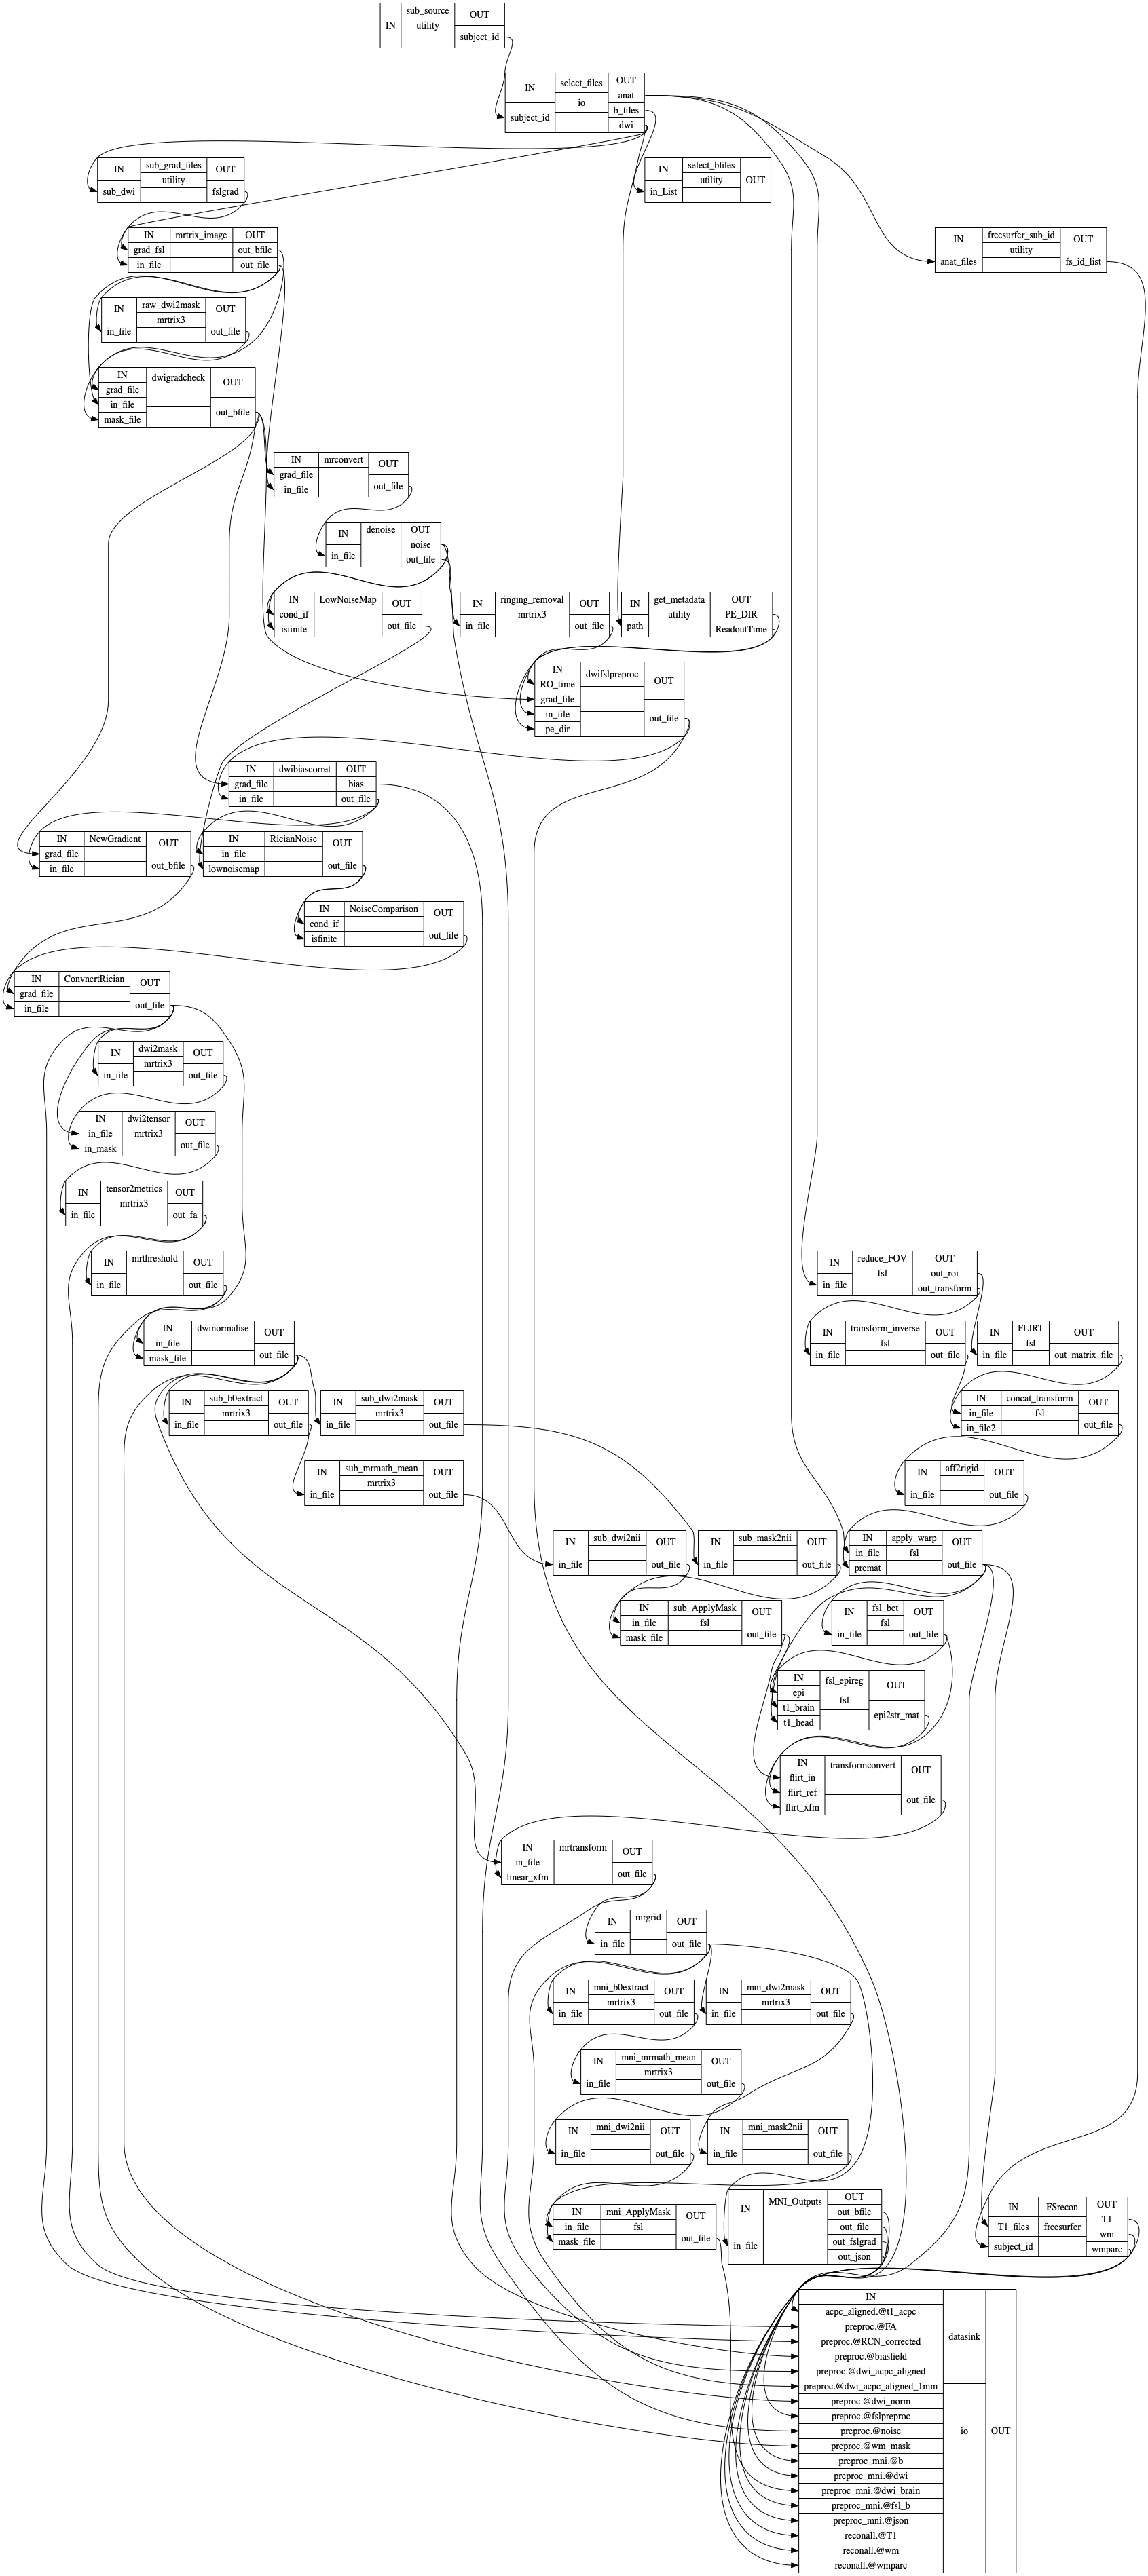

In [ ]:
#example
from IPython.display import Image
Image('/Users/xxie/sample_data/derivatives/pipetography/pipetography_detailed.png')

In [ ]:
preproc_dwi.run_pipeline(parallel = True)

Number of Processes:  4
